### Spectral Relaxation for K-means Clustering

First version

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist 
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
A = np.array([[1,1,4,5,5], [1, 2,1,1,2]]) #jednostavna matrica 
print(A)
print(pd.DataFrame(A))

[[1 1 4 5 5]
 [1 2 1 1 2]]
   0  1  2  3  4
0  1  1  4  5  5
1  1  2  1  1  2


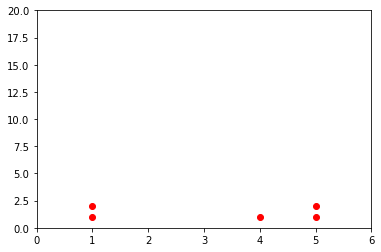

In [4]:
A = np.array([[1,1,4,5,5], [1, 2,1,1,2]]) #jednostavan primjer
plt.plot(A[0,:],A[1,:], 'ro')
plt.axis([0, 6, 0, 20])
plt.show()

In [35]:
#""""
centri = np.array([[10, 2], [-4, 3]], dtype=float)
A = [np.random.randn(2, 50) + np.expand_dims(centar, axis=1) 
    for centar in centri]
A = np.concatenate(A, axis=1)
#"""

A = pd.DataFrame(A)
print(A)
nmax = 5
k = 3

while True:
    starting_partition = np.random.randint(0, k, A.shape[1])
    s_i = np.unique(starting_partition, axis=0, return_counts=True)[1]
    if len(s_i) == k:
        break

A.columns = starting_partition 

for n in tqdm(range(nmax)):
    s_i = np.unique(starting_partition, axis=0, return_counts=True)[1]
    a_i = A.groupby(level=0,axis=1).sum().add_suffix('_centroid_klastera')
    m_i = a_i / s_i 
    for i in range(A.shape[1]): 
        distance_final = np.inf
        for j in range(0, m_i.shape[1]):
            distance = np.linalg.norm((A.iloc[:,i] - m_i.iloc[:,j]))
            if(distance < distance_final):
                distance_final = distance
                tmp = list(A.columns)
                tmp[i] = j
                A.columns = tmp  
    starting_partition = A.columns.values 

print(A)   
print(m_i)

         0         1          2         3          4         5          6   \
0  8.044549  9.883210  10.303079  9.495095  10.040599  8.177206  10.832563   
1  2.225365  3.152283   2.190810  2.518609  -0.086184  1.331959   2.344524   

         7         8         9   ...        90        91        92        93  \
0  9.566723  9.501055  9.701080  ... -3.458766 -4.212722 -3.342893 -4.639311   
1  1.562739  3.378033  1.761686  ...  1.922130  3.430442  1.554050  4.502817   

         94        95        96        97        98        99  
0 -4.363386 -3.737367 -4.194781 -4.876594 -5.025584 -5.427860  
1  4.640729  1.473368  1.927335  4.679656  3.354687  3.828168  

[2 rows x 100 columns]


100%|██████████| 5/5 [00:01<00:00,  4.82it/s]

          0         0          0         0          0         0          0  \
0  8.044549  9.883210  10.303079  9.495095  10.040599  8.177206  10.832563   
1  2.225365  3.152283   2.190810  2.518609  -0.086184  1.331959   2.344524   

          0         0         0  ...         1         1         1         1  \
0  9.566723  9.501055  9.701080  ... -3.458766 -4.212722 -3.342893 -4.639311   
1  1.562739  3.378033  1.761686  ...  1.922130  3.430442  1.554050  4.502817   

          1         1         1         1         1         1  
0 -4.363386 -3.737367 -4.194781 -4.876594 -5.025584 -5.427860  
1  4.640729  1.473368  1.927335  4.679656  3.354687  3.828168  

[2 rows x 100 columns]
   0_centroid_klastera  1_centroid_klastera
0             9.941625            -3.861249
1             1.854261             2.786620


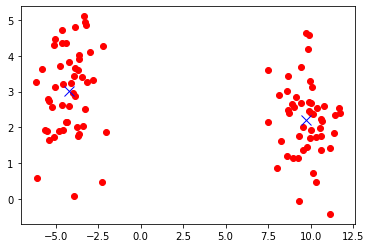

In [34]:
plt.plot(A.iloc[0,:],A.iloc[1,:], 'ro')
plt.plot(m_i.iloc[0,:],m_i.iloc[1,:], 'bx', ms=10)
plt.show()
#plavi centroidi

## 9. prosinac 2021.

In [1]:
import scipy.io
import numpy as np
from scipy.sparse.linalg import eigs

mat_1 = scipy.io.loadmat('azip.mat')
A = mat_1['azip']
mat_2 = scipy.io.loadmat('dzip.mat')
D = mat_2['dzip']

In [77]:
##karlov kod
U, S, V = np.linalg.svd(np.matmul(np.transpose(A),A))
V = V[0:k, :]
Q, R = np.linalg.qr(np.transpose(V))
R_1 = R[0:k, 0:k]
R_2 = R[0:k, (k+1):k]

In [256]:
new_A = np.empty([256,0])
k = 10

for i in range(k):
    new_A = np.append(new_A, A[:, np.where(D == i)[1]], axis=1)
    
#U, S, V = np.linalg.svd(np.matmul(np.transpose(new_A),new_A))

#vals, vecs = eigs(np.matmul(np.transpose(new_A),new_A), k=k, which = 'LM') 


In [321]:
J = np.random.rand(2,2)

U, S, V = np.linalg.svd(J)

w, v = np.linalg.eig(np.matmul(np.transpose(J), J)) #w su sv. vrijednosti

np.sqrt(v)

/var/folders/d3/xr9k6gp148s_pc6q399vjm2h0000gn/T/ipykernel_1305/1397814190.py:7: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(v)


array([[0.88580754,        nan],
       [0.78735804, 0.88580754]])

In [339]:
from scipy.sparse.linalg import eigs

J = np.eye(13)

vals, vecs = eigs(np.matmul(np.transpose(J), J), k=2) 
U, S, V = np.linalg.svd(J)
vecs

array([[-0.44551602+0.j,  0.16750043+0.j],
       [-0.16620967+0.j, -0.10194002+0.j],
       [-0.41719061+0.j, -0.24847232+0.j],
       [ 0.22978774+0.j,  0.08776993+0.j],
       [ 0.24323818+0.j, -0.01166536+0.j],
       [ 0.34393676+0.j,  0.22861141+0.j],
       [ 0.02774591+0.j,  0.39844225+0.j],
       [ 0.18511181+0.j,  0.34657747+0.j],
       [-0.00916476+0.j,  0.03832912+0.j],
       [ 0.12484411+0.j, -0.34969772+0.j],
       [ 0.25373141+0.j, -0.45979354+0.j],
       [-0.50265369+0.j,  0.1437756 +0.j],
       [ 0.04284254+0.j, -0.45276839+0.j]])

## 14.12.2021.

In [2]:
import scipy.io
import numpy as np
from scipy.sparse.linalg import eigs

Učitavanje podataka

In [85]:
mat_1 = scipy.io.loadmat('azip.mat')
A = mat_1['azip'] #data

mat_2 = scipy.io.loadmat('dzip.mat')
D = mat_2['dzip'] #data

k = 10 #number of claster

Prvo ćemo presložiti matricu podataka(**A**) na način da združimo one elemente koji pripadaju istom klasteru i napravimo od njih blokove. Nakon toga, pomoću kreiranih blokova, računamo broj elementa klastera(**$s_i$**) i nove centroide (**$m_i$**) pomoću formula s prezentacije(*prva prezentacija - slajd 35*).

In [172]:
import numpy as np
arr = np.array([[1,2,3],[4,5,6]])
print(arr.shape)
row = np.array([7,8,9])
print(row.shape)
arr = np.vstack([arr,row])
print(arr)

(2, 3)
(3,)
[[1 2 3]
 [4 5 6]
 [7 8 9]]


In [179]:
new_A = np.empty([A.shape[0],0])
s_i = np.empty(k, dtype=int) 
m_i = np.empty([A.shape[0],k])
permutation = np.empty(0,) 

for i in range(k):
    A_i = A[:, np.where(D == i)[1]] #ovo je 319 puta 0
    print(permutation.shape,np.where(D == i)[1].shape) 
    permutation = np.append(permutation, np.where(D == i)[1], axis=0) #ovo ide po retcima
    np.where(D == i)[1]
    new_A = np.append(new_A, A_i, axis=1)
    s_i[i] = np.where(D == i)[1].shape[0]
    e = np.ones(s_i[i])
    m_i[:,i] = (1/s_i[i]) * np.matmul(A_i, e) 


(0,) (319,)
(319,) (252,)
(571,) (202,)
(773,) (131,)
(904,) (122,)
(1026,) (88,)
(1114,) (151,)
(1265,) (166,)
(1431,) (144,)
(1575,) (132,)


array([   8.,   11.,   18., ..., 1701., 1703., 1705.])

Konačno, formuliramo matricu X koja će sadržavati informacije o pripadnosti elementa početnoj particiji.

In [144]:
X = np.zeros([A.shape[1],k])

for i in range(k):
    if( i == 0):
        X[i:s_i[i], 0] = 1/s_i[1]
    else:
        X[ s_i[0:i].sum() : s_i[0:i].sum() + s_i[i], i] = 1/s_i[i-1]

0.011363636363636364

Na kraju, preostaje ponovo inverzno djelovati istom permutacijom na matricu $X$ kako bismo dobili $\tilde{X}$.

In [202]:
X_tilde = np.zeros([A.shape[1],k])

for i in range(X.shape[0]):
    index = list(permutation).index(i)  #daje indeks retka 
    X_tilde[int(permutation[i]), :] = X[i, :] 

Preostaje zapisati početnu particiju.

In [243]:
start_partition = np.empty(D.shape[1], dtype=int)

for i in range(X.shape[0]):
    start_partition[i] = int(np.where(X_tilde[i, :] != 0)[0])

In [245]:
from sklearn.metrics import accuracy_score

start_partition = np.reshape(start_partition, (D.shape[1],1))
accuracy_score(start_partition, np.transpose(D))

1.0

Vidimo da se ova početna particija 100% podudara s točnim rješenjima, pa možemo reći da je idealna, odnosno da je naš algoritam jako dobar.